In [55]:
%matplotlib inline

Building feed-forward neural network...
'build' took 0.032996 s

Compiling model...
'compile' took 0.421212 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [4.91e+01, 5.68e-02]    [5.26e+01, 0.00e+00]    [1.20e+00]    
Epoch 1: train loss improved from inf to 4.91e+01, saving model to ./model/model.ckpt-1 ...

INFO:tensorflow:./model/model.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
1000      [1.17e+01, 4.13e+00]    [1.22e+01, 0.00e+00]    [1.34e+00]    
Epoch 1000: train loss improved from 4.91e+01 to 1.58e+01, saving model to ./model/model.ckpt-1000 ...

INFO:tensorflow:./model/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [5.26e+00, 6.53e+00]    [5.25e+00, 0.00e+00]    [1.91e+00]    
Epoch 2000: train loss improved from 1.58e+01 to 1.18e+01, saving model to ./model/model.ckpt-2000 ...

INFO:tensorflow:./model/model.ckpt-2000 is not in all_mode

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Saving the movie of spectrum to model/movie_spectrum.txt, model/movie_spectrum.gif...


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.



Best model at step 10000:
  train loss: 9.92e+00
  test loss: 3.56e+00
  test metric: [1.90e+00]

'train' took 36.136420 s



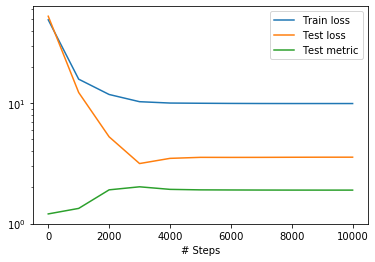

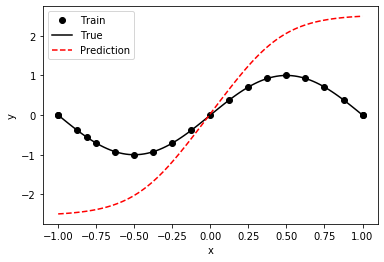

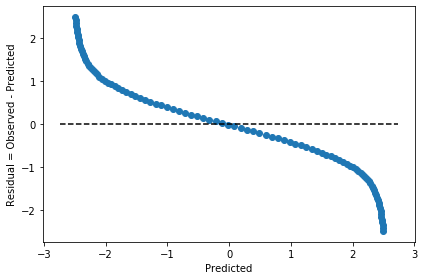

Saving loss history to loss.dat ...
Saving training data to train.dat ...
Saving test data to test.dat ...
Predicting...
'predict' took 0.491637 s



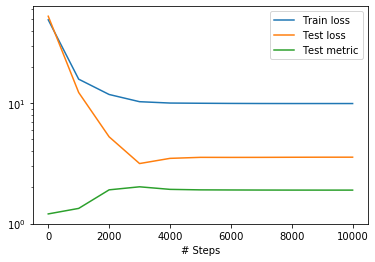

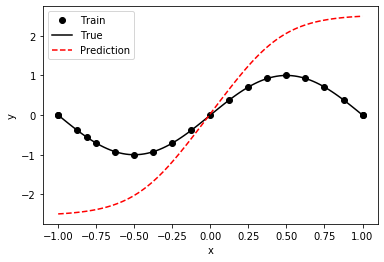

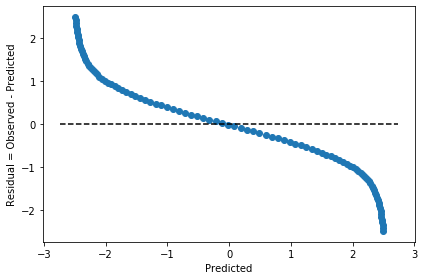

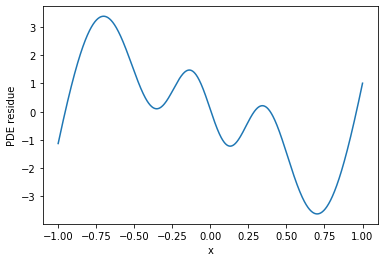

In [56]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import deepxde as dde

def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_xx = tf.gradients(dy_x, x)[0]
    return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)

def boundary(x, on_boundary):
    return on_boundary

def func(x):
    return np.sin(np.pi * x)

def plot_loss_history(losshistory,filename="losshistory.jpeg"):
    loss_train = np.sum(
        np.array(losshistory.loss_train) * losshistory.loss_weights, axis=1
    )
    loss_test = np.sum(
        np.array(losshistory.loss_test) * losshistory.loss_weights, axis=1
    )

    plt.figure()
    plt.semilogy(losshistory.steps, loss_train, label="Train loss")
    plt.semilogy(losshistory.steps, loss_test, label="Test loss")
    for i in range(len(losshistory.metrics_test[0])):
        plt.semilogy(
            losshistory.steps,
            np.array(losshistory.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("# Steps")
    plt.legend()
    if filename:
        plt.savefig(filename)

def plot_best_state(train_state,solution_filename="pdesolution.jpeg",residual_filename="pderesidual.jpeg"):
    X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()

    y_dim = y_train.shape[1]

    # Regression plot
    plt.figure()
    idx = np.argsort(X_test[:, 0])
    X = X_test[idx, 0]
    for i in range(y_dim):
        plt.plot(X_train[:, 0], y_train[:, i], "ok", label="Train")
        plt.plot(X, y_test[idx, i], "-k", label="True")
        plt.plot(X, best_y[idx, i], "--r", label="Prediction")
        if best_ystd is not None:
            plt.plot(X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI")
            plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    if solution_filename:
        plt.savefig(solution_filename)

    # Residual plot
    plt.figure()
    residual = y_test[:, 0] - best_y[:, 0]
    plt.plot(best_y[:, 0], residual, "o", zorder=1)
    plt.hlines(0, plt.xlim()[0], plt.xlim()[1], linestyles="dashed", zorder=2)
    plt.xlabel("Predicted")
    plt.ylabel("Residual = Observed - Predicted")
    plt.tight_layout()

    if best_ystd is not None:
        plt.figure()
        for i in range(y_dim):
            plt.plot(X_test[:, 0], best_ystd[:, i], "-b")
            plt.plot(
                X_train[:, 0],
                np.interp(X_train[:, 0], X_test[:, 0], best_ystd[:, i]),
                "ok",
            )
        plt.xlabel("x")
        plt.ylabel("std(y)")

    if residual_filename:
        plt.savefig(residual_filename)

geom = dde.geometry.Interval(-1, 1)
bc = dde.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, 1, pde, bc, 16, 2, func=func, num_test=100)

layer_size = [1] + [2] * 1 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

checkpointer = dde.callbacks.ModelCheckpoint(
    "./model/model.ckpt", verbose=1, save_better_only=True
)
movie = dde.callbacks.MovieDumper(
    "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
)
losshistory, train_state = model.train(
    epochs=10000, callbacks=[checkpointer, movie]
)

dd = dde.saveplot(losshistory, train_state, issave=True, isplot=True)

plot_loss_history(losshistory)
plot_best_state(train_state)

# Plot PDE residue
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residue")
plt.show()

In [57]:
import mlflow
from  mlflow.tracking import MlflowClient
mlflow_params  = {}
mlflow_metrics = {}

In [58]:
tracking_uri = "https://j1002148222.babyrocket.net/mlflow"
client = MlflowClient(tracking_uri=tracking_uri)
mlflow.set_tracking_uri(tracking_uri)
experiments = client.list_experiments()
experiment_names = []
for exp in experiments:
    experiment_names.append(exp.name)
experiment_name = "sciml_demo"
if experiment_name not in experiment_names:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

In [59]:
losshistory.metrics_test[-1][0]

1.8957987

In [60]:
mlflow_params["layers"] = layer_size
mlflow_metrics["accuracy"] = losshistory.metrics_test[-1][0]
mlflow_params["steps"] = losshistory.steps[-1]
with mlflow.start_run():
    mlflow.log_params(mlflow_params)
    mlflow.log_metrics(mlflow_metrics)
    mlflow.log_artifact("losshistory.jpeg")
    mlflow.log_artifact("pderesidual.jpeg")
    mlflow.log_artifact("pdesolution.jpeg")